# Analysis of Proportional-Integral Controller

## Learning Objectives

In this notebook, we will use a mathematical model for the TCLab to design and analyze a PI controller.

After studying this notebook and completing the activities, you will be able to:
* Agument dynamic system model with PI feedback control law to predict closed loop dynamics
* Analyze stability of a (linear) system
* Perform senstivity analysis to tune controller

First review the [proportional only controller notes](../tclab/04-TCLab-P-Controller-Analysis.ipynb) for modeling details.


## Proporational-Integral Control Law

We will consider the proporational control law:

$$
u_{1} = u^*_{1} - K_p (T_{S,1}-T_{set}) - K_i \int_{0}^{t} (T_{S,1}(t) - T_{set}) dt
$$

Here, $K_p > 0$ is the proportional gain, $K_i > 0$ is the integral gain, and $T_{S,1}-T_{set}$ is the tracking error.

## Closed-Loop Dynamics

How can we model the integral in the control law? Let's add a new state to our model for the integral:
$$
\begin{align}
C^H_p\frac{dT^*_{H,1}}{dt} & = -U_a T^*_{H,1} + U_b(T^*_{S,1} - T^*_{H,1}) - \alpha P_1 K_p T^*_{S,1} - \alpha P_1 K_i I\\
C^S_p\frac{dT^*_{S,1}}{dt} & = U_b(T^*_{H,1} - T^*_{S,1}) \\
\frac{dI}{dt} &= T^{*}_{S,1}
\end{align}
$$

Let's collect similar terms:

$$
\begin{align}
\frac{dT^*_{H,1}}{dt} & = \left(-\frac{U_a + U_b}{C^H_p} \right)  T^*_{H,1} + \left(\frac{U_b - \alpha P_1 K_p}{C_p^H} \right) T^*_{S,1} + \left(\frac{- \alpha P_1 K_I}{C_p^H} \right) I  \\
\frac{dT^*_{S,1}}{dt} & = \left(\frac{U_b}{C_p^S} \right) T^*_{H,1} + \left(-\frac{U_b}{C_p^S} \right) T^*_{S,1} \\
\frac{dI}{dt} &= T^{*}_{S,1}
\end{align}
$$

Finally, we can write this as a linear differential equation in matrix form:

$$
\begin{align}
\frac{d}{dt}\underbrace{\begin{bmatrix} T^*_{H,1} \\ T^*_{S,1 \\ I} \end{bmatrix}}_\mathbf{x} & = 
\underbrace{\begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b - \alpha P_1 K_p}{C^H_p} & \frac{- \alpha P_1 K_i}{C^H_p} \\ 
\frac{U_b}{C^S_p} & - \frac{U_b}{C^S_p} & 0 \\
0 & 0 & 1 \end{bmatrix}}_\mathbf{A} 
\underbrace{\begin{bmatrix} T^*_{H,1} \\ T^*_{S,1} \end{bmatrix}}_\mathbf{x} \\
\\
\underbrace{\begin{bmatrix} T^*_{S,1}\end{bmatrix}}_\mathbf{y} & = 
\underbrace{\begin{bmatrix}0 & 1 & 0 \end{bmatrix}}_\mathbf{C} 
\underbrace{\begin{bmatrix} T^*_{H,1} \\ T^*_{S,1} \\ I \end{bmatrix}}_\mathbf{x}
\end{align}
$$

This system describes the closed loop dynamics. Take a few minutes to compare to the model for [open loop dynamics](../notebooks/02.05-Second-Order.ipynb). Notice the above model does not include $u$ or $\mathbf{B}$ because the control law is embedded in the closed loop model.



## Numeric Simulation -- LEFT OFF HERE

Let's simulate the above system two ways to verify our math is correct.

### Original Model: Open Loop

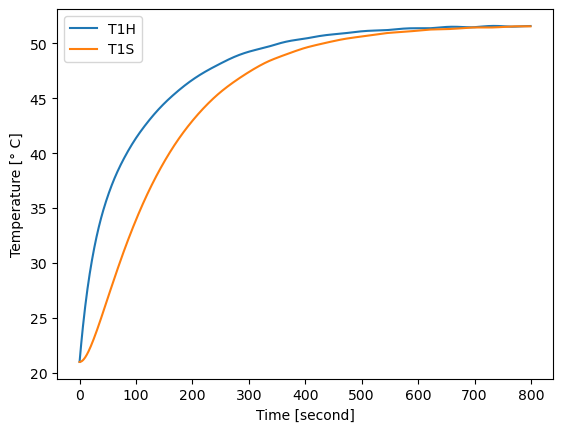

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# parameters
T_amb = 21 # deg C
alpha = 0.00016 # watts / (units P1 * percent U1)
P1 = 100 # P1 units
U1 = 50 # steady state value of u1 (percent)

# fiited parameters (see previous lab)
Ua = 0.0261 # watts/deg C
Ub = 0.0222 # watts/deg C
CpH = 1.335 # joules/deg C
CpS = 1.328 # joules/deg C

t_final = 800
t_step = 1
t_expt = np.arange(0,t_final,t_step)

# model solution
def deriv(t, y):
    # right hand side of differential equation
    T1H, T1S = y
    dT1H = (-(Ua + Ub)*T1H + Ub*T1S + alpha*P1*U1 + Ua*T_amb)/CpH
    dT1S = Ub*(T1H - T1S)/CpS
    return [dT1H, dT1S]

# numerical integrate
soln_original = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb, T_amb], t_eval=t_expt)

# plot
plt.plot(soln_original.t, soln_original.y[0],label='T1H')
plt.plot(soln_original.t, soln_original.y[1],label='T1S')
plt.legend()
plt.xlabel('Time [second]')
plt.ylabel('Temperature [° C]')
plt.grid()
plt.show()

Compare this plot to our model identification lab. This is a simulation of a step response.

### New Model: Open Loop

Now let's simulate the new model. We'll set $K_p = 0$ to turn off the controller (no gain).

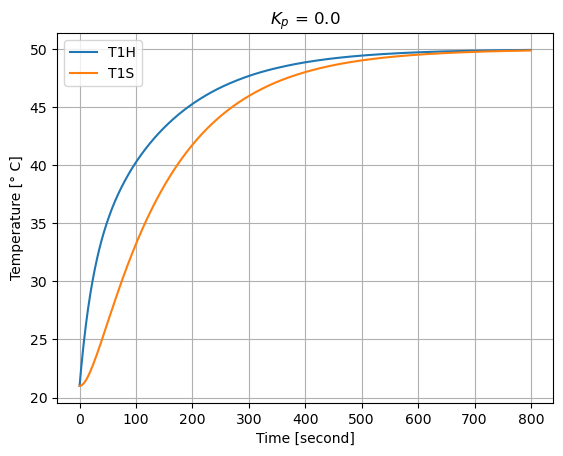

In [9]:
def simulate_response(Kp=0.0):

    A = np.array([[-(Ua + Ub)/CpH, (Ub - alpha*P1*Kp)/CpH], 
                [Ub/CpS, -Ub/CpS]])
    T_set = 50

    # model solution
    def closed_loop(t, y):
        return A @ y
    soln_P = solve_ivp(closed_loop, [min(t_expt), max(t_expt)], [T_amb - T_set, T_amb-T_set], t_eval=t_expt)

    plt.plot(soln_P.t, soln_P.y[0] + T_set,label='T1H')
    plt.plot(soln_P.t, soln_P.y[1] + T_set,label='T1S')
    plt.title("$K_p$ = "+str(Kp))
    plt.grid()
    plt.legend()
    plt.xlabel('Time [second]')
    plt.ylabel('Temperature [° C]')
    plt.show()

simulate_response(Kp=0.0)

This matches our original model. We did not make a math mistake!

### New Model: Closed Loop

Now let's look at the closed loop response for a few different Kp values.

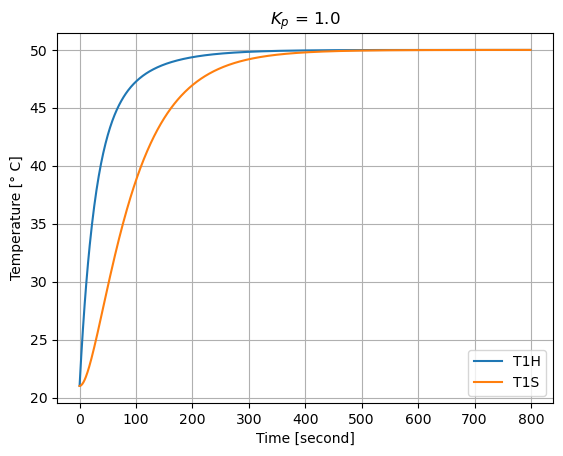

In [10]:
simulate_response(Kp=1.0)

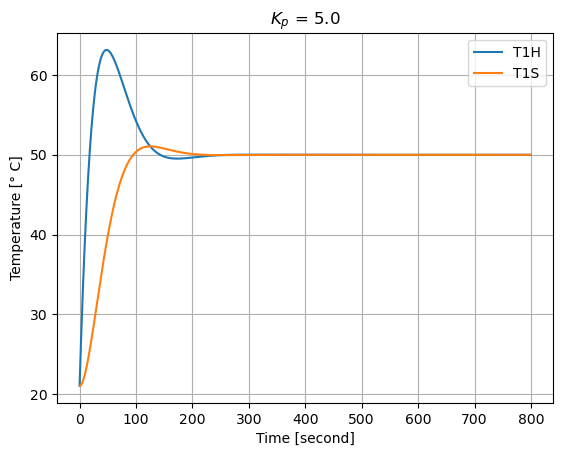

In [11]:
simulate_response(Kp=5.0)

Perform a simple sensitivity analysis and answer the following discussion questions:
* What happens with small and large $K_p$ values? Does the solution overshoot or undershoot? How long does it take to reach the set point?
* Can you find the value of $K_p$ that is the transition between overshoot and undershoot?

## Stability Analysis

We will now perform a more sophisticated analysis to understand how the choice of $K_p$ impacts the closed loop dynamics. Specifcally, we'll inspect the eigenvalues of $\mathbf{A}$.

In [13]:
# Eigendecomposition analysis
from scipy.linalg import eig

def calc_eig(Kp,verbose=True):

    A = np.array([[-(Ua + Ub)/CpH, (Ub - alpha*P1*Kp)/CpH], 
              [Ub/CpS, -Ub/CpS]])
    
    w, vl = eig(A)

    if verbose:
        for i in range(len(w)):
            print("Eigenvalue",i,"=",w[i])
            print("Eigenvector",i,"=",vl[:,i],"\n")

    return w

calc_eig(Kp=0.1)

Eigenvalue 0 = (-0.04522741496569595+0j)
Eigenvector 0 = [-0.86264796  0.5058048 ] 

Eigenvalue 1 = (-0.007669227785082447+0j)
Eigenvector 1 = [-0.47598497 -0.87945342] 



array([-0.04522741+0.j, -0.00766923+0.j])

In [14]:
calc_eig(Kp=10.0)

Eigenvalue 0 = (-0.0264483213753892+0.04038353802879882j)
Eigenvector 0 = [ 0.92769638+0.j         -0.08746124-0.36294622j] 

Eigenvalue 1 = (-0.0264483213753892-0.04038353802879882j)
Eigenvector 1 = [ 0.92769638-0.j         -0.08746124+0.36294622j] 



array([-0.02644832+0.04038354j, -0.02644832-0.04038354j])

Here are rules for interpretting the eigenvalues and eigenvectors:
* If all of the real components of the eigenvalues are negative, the system is stable and will return to the steady state ($T^*_{S,1} \rightarrow 0$, $T^*_{H,1} \rightarrow 0$).
* The eigenvectors corresponding to any eigenvalues with a positive real component shows the direction of exponential growth.
* If any of the eigenvalues have non-zero imaginary components, the system osciallates.

Let's perform a sensitivity analysis to see how the eigenvalues change.

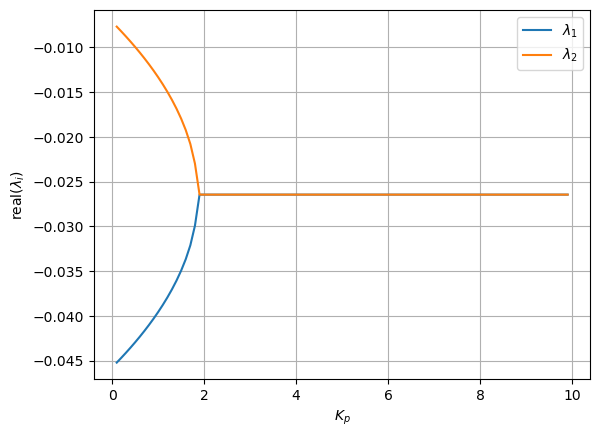

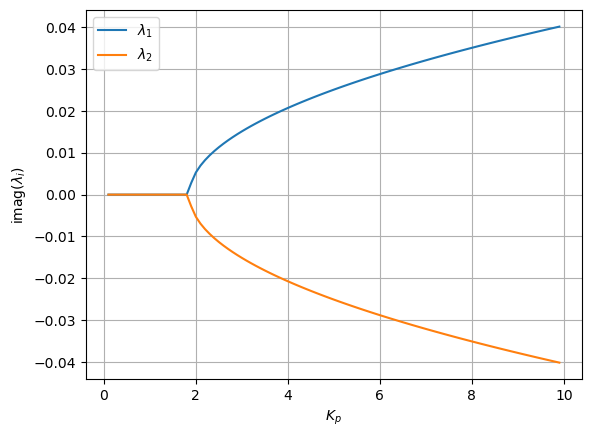

In [19]:
Kp_range = np.arange(0.1,10,0.1)
n = len(Kp_range)
eig_values = np.zeros((n,2), dtype=complex)

for i,kp in enumerate(Kp_range):
    eig_values[i,:] = calc_eig(kp, verbose=False)[:]

plt.figure()
plt.plot(Kp_range, np.real(eig_values))
plt.xlabel("$K_p$")
plt.ylabel("real($\lambda_i$)")
plt.legend(['$\lambda_1$','$\lambda_2$'])
plt.grid()

plt.figure()
plt.plot(Kp_range, np.imag(eig_values))
plt.xlabel("$K_p$")
plt.ylabel("imag($\lambda_i$)")
plt.legend(['$\lambda_1$','$\lambda_2$'])
plt.grid()

Interpret the plots above to find the value of $K_p$ that is the transition from undershooting (no oscillations) and overshooting (with oscillations).

In [21]:
### BEGIN SOLUTION
calc_eig(1.8, verbose=True)
### END SOLUTION

Eigenvalue 0 = (-0.02992049758398236+0j)
Eigenvector 0 = [-0.61982077  0.78474341] 

Eigenvalue 1 = (-0.022976145166796035+0j)
Eigenvector 1 = [ 0.35065447 -0.93650491] 



array([-0.0299205 +0.j, -0.02297615+0.j])

## Simulate Performance with TC Lab

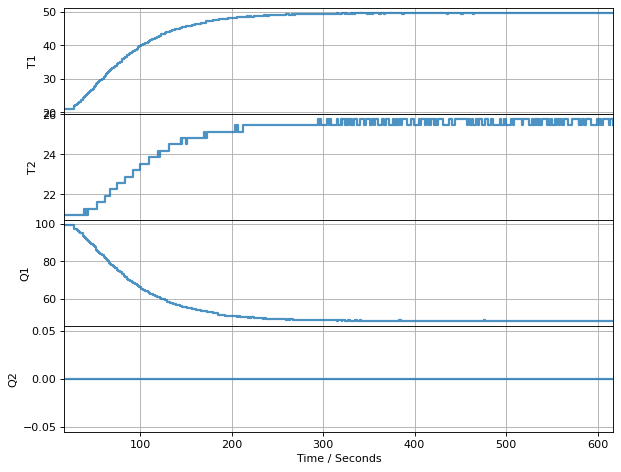

TCLab Model disconnected successfully.


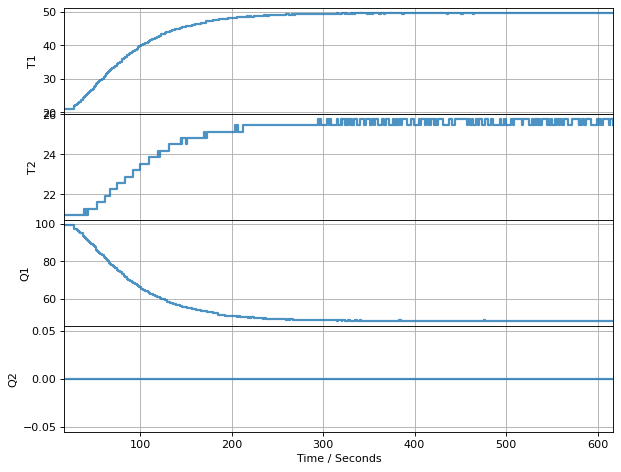

In [25]:
def P_only(Kp=1, MV_bar=0):
    """ Basic proportional only controller

    Arguments:
        Kp: proportional gain
        MV_bar: steady-state value for manipulated variable

    """
    # Minimum and maximum bounds for manipulated variables
    MV_min = 0
    MV_max = 100

    # Initialize with MV_bar
    MV = MV_bar

    while True:
        SP, PV, MV = yield MV
        e = PV - SP # calculate error
        MV = MV_bar - Kp*e # apply control law
        MV = max(MV_min, min(MV_max, MV)) # Apply upper and lower bounds

%matplotlib inline
from tclab import setup, clock, Historian, Plotter

# Initialize in simulation mode
TCLab = setup(connected=False, speedup = 20)

SP = 50 # set point, deg C
tfinal = 600 # simulation horizon, seconds
t_step = 1 # time step, seconds
u_star = Ua*(SP-T_amb) / (alpha*100) # u at steady-state
print("MV_bar =",u_star)

# create control loop
controller1 = P_only(Kp=1.8, MV_bar=u_star)
controller1.send(None)

with TCLab() as lab:
    h = Historian(lab.sources)
    p = Plotter(h, tfinal)
    for t in clock(tfinal, t_step):
        PV = lab.T1                                     # measure the the process variable
        MV = lab.U1                                     # get manipulated variable
        MV = controller1.send([SP, PV, MV])             # P control to determine the MV
        lab.Q1(MV)                                      # set the heater power
        p.update()                                      # log data